# Airdrops -- Exploratory Data Analysis

**[Johnnatan Messias](https://johnnatan-messias.github.io/), May 2025**.


In [1]:
# Standard Library Imports
import os
import gzip
import pickle
import json

# Third-Party Libraries
import polars as pl
import pandas as pd
from tqdm.notebook import tqdm
from IPython.display import display, HTML

# Polars Configuration
pl.Config.set_float_precision(18)

polars.config.Config

In [2]:
import sys
code_dir = os.path.realpath(os.path.join(os.getcwd(), "..", "src"))

sys.path.append(code_dir)

In [3]:
import plotly.graph_objects as go
from plot_utils import get_plotly_layout, colors, percentiles, ECDF
import networkx as nx

In [4]:
protocols = ["ens", "dydx", "1inch", "gemstone", "arbitrum",
             "optimism", "uniswap", "arkham", "lido", "tornado"]

In [5]:
# Define shared attributes to avoid redundancy
common_styles = {
    "width": [4.25, 4, 3.75, 3.5, 3.25, 3, 2.75, 2.5, 2.25, 2],
    "style": ["solid", "dash", "dot", "dashdot", "solid", "dash", "dash", "dot", "dashdot", "solid"]
}

labels = ["ENS", "DYDX", "1inch", "Gemstone", "Arbitrum",
          "Optimism", "Uniswap", "Arkham", "Lido", "TornadoCash"]
colors_list = [
    colors["blue"], colors["red"], colors["green"], colors["grey"], colors["pink"],
    colors["orange"], colors["brown"], colors["light_yellow"], colors["black"], colors["purple"]
]

# Construct plot settings using a dictionary comprehension
plot_settings = {
    protocol: {
        "color": colors_list[i],
        "label": labels[i],
        "style": common_styles["style"][i],
        "width": common_styles["width"][i]
    }
    for i, protocol in enumerate(protocols)
}

In [140]:
data_dir = os.path.realpath(os.path.join(os.getcwd(), "..", "data"))
plots_dir = os.path.realpath(os.path.join(data_dir, "..", "plots"))
graph_dir = os.path.join(data_dir, "graphs")

os.makedirs(data_dir, exist_ok=True)
os.makedirs(plots_dir, exist_ok=True)
os.makedirs(graph_dir, exist_ok=True)

In [7]:
# Loading dead/null addresses
dead_addresses = pl.read_csv(os.path.join(
    data_dir, "dead_addresses.csv"))['address']

In [8]:
decimals = 1e18

# Loading data


In [9]:
from pathlib import Path


def load_dataset(protocols):
    # Define base data directory
    base_path = Path(data_dir)

    # Load datasets using dictionary comprehension
    return {
        protocol: {
            'transfer': pl.scan_parquet(base_path / f"{protocol}_transfer.parquet"),
            'claim': pl.scan_parquet(base_path / f"{protocol}_claim.parquet")
        }
        for protocol in tqdm(protocols)
    }

In [10]:
# Load the dataset once
dfs = load_dataset(protocols)

# Define protocols with 'to' as receiver in claim
to_receiver_protocols = {"1inch", "uniswap", "lido", "tornado", "optimism"}

for protocol, data in dfs.items():
    print(protocol)

    # Rename for 'transfer'
    data['transfer'] = data['transfer'].rename(
        {"from": "sender", "to": "receiver"})

    # Determine claim renaming based on protocol
    claim_rename = {"to": "receiver"} if protocol in to_receiver_protocols else {
        "account": "receiver"}

    # Apply renaming for 'claim'
    data['claim'] = data['claim'].rename(claim_rename)

  0%|          | 0/10 [00:00<?, ?it/s]

ens
dydx
1inch
gemstone
arbitrum
optimism
uniswap
arkham
lido
tornado


In [11]:
for protocol, data in dfs.items():
    print(protocol)

    for data_type in ["claim", "transfer"]:
        result = (
            data[data_type]
            .select([
                pl.min('timestamp').alias("min_timestamp"),
                pl.max('timestamp').alias("max_timestamp")
            ])
            .collect()
        )

        min_timestamp = result["min_timestamp"].item()
        max_timestamp = result["max_timestamp"].item()

        print(f"\t{data_type}: min_date={min_timestamp}\tmax_date={max_timestamp}")

ens
	claim: min_date=2021-11-09 00:01:26	max_date=2024-08-04 04:28:23
	transfer: min_date=2021-11-01 20:55:17	max_date=2024-10-19 13:35:47
dydx
	claim: min_date=2021-09-08 05:24:48	max_date=2024-10-18 18:32:35
	transfer: min_date=2021-07-12 01:37:12	max_date=2024-10-19 13:45:47
1inch
	claim: min_date=2020-12-25 00:08:54	max_date=2024-10-18 21:35:47
	transfer: min_date=2020-12-23 18:13:31	max_date=2024-10-19 13:45:47
gemstone
	claim: min_date=2023-07-23 21:50:55	max_date=2023-09-11 08:47:07
	transfer: min_date=2023-07-18 07:43:39	max_date=2023-09-11 08:47:17
arbitrum
	claim: min_date=2023-03-23 13:01:22+00:00	max_date=2023-09-24 20:12:52+00:00
	transfer: min_date=2023-03-16 12:08:28+00:00	max_date=2024-05-14 23:59:58+00:00
optimism
	claim: min_date=2022-05-31 14:39:05	max_date=2023-07-11 21:41:05
	transfer: min_date=2022-04-26 13:42:36	max_date=2024-03-24 23:59:49
uniswap
	claim: min_date=2020-09-16 21:32:52	max_date=2024-10-19 13:33:11
	transfer: min_date=2020-09-14 18:11:26	max_date=2

In [12]:
for protocol, data in dfs.items():
    print(protocol)
    for data_type in ["claim", "transfer"]:
        result = (
            data[data_type]
            .select([
                pl.min('blockNumber').alias("min_block"),
                pl.max('blockNumber').alias("max_block")
            ])
            .collect()
        )

        min_block = result["min_block"].item()
        max_block = result["max_block"].item()

        print(f"\t{data_type}: min_block={min_block}\tmax_block={max_block}")

ens
	claim: min_block=13578843	max_block=20452797
	transfer: min_block=13533418	max_block=20999950
dydx
	claim: min_block=13183164	max_block=20994261
	transfer: min_block=12809555	max_block=21000000
1inch
	claim: min_block=11519481	max_block=20995174
	transfer: min_block=11511393	max_block=21000000
gemstone
	claim: min_block=9375492	max_block=13566160
	transfer: min_block=8898950	max_block=13566160
arbitrum
	claim: min_block=72829612	max_block=134244706
	transfer: min_block=70398215	max_block=211336634
optimism
	claim: min_block=9401026	max_block=106756444
	transfer: min_block=6491116	max_block=117863006
uniswap
	claim: min_block=10875578	max_block=20999937
	transfer: min_block=10861674	max_block=20999993
arkham
	claim: min_block=17718694	max_block=20741142
	transfer: min_block=17628655	max_block=20999848
lido
	claim: min_block=11596109	max_block=20752853
	transfer: min_block=11473276	max_block=20999995
tornado
	claim: min_block=11474827	max_block=15322201
	transfer: min_block=11474599

In [13]:
for protocol, data in dfs.items():
    transfer_count = data['transfer'].select(pl.len()).collect().item()
    claim_count = data['claim'].select(pl.len()).collect().item()

    print(
        f"There are {transfer_count} Transfer and {claim_count} claiming events for {protocol}")

There are 998619 Transfer and 102824 claiming events for ens
There are 747372 Transfer and 72870 claiming events for dydx
There are 1782998 Transfer and 43806 claiming events for 1inch
There are 261896 Transfer and 21778 claiming events for gemstone


There are 47330340 Transfer and 583137 claiming events for arbitrum
There are 43990557 Transfer and 160603 claiming events for optimism
There are 4872925 Transfer and 221087 claiming events for uniswap
There are 283775 Transfer and 64724 claiming events for arkham
There are 1107586 Transfer and 516 claiming events for lido
There are 278455 Transfer and 5474 claiming events for tornado


In [14]:
for protocol, data in dfs.items():
    claim_count = data['claim'].select(
        pl.n_unique('receiver')).collect().item()
    print(f"{protocol}: There are {claim_count} accounts receiving the airdrop")

ens: There are 102824 accounts receiving the airdrop
dydx: There are 45944 accounts receiving the airdrop
1inch: There are 43806 accounts receiving the airdrop
gemstone: There are 20014 accounts receiving the airdrop
arbitrum: There are 583137 accounts receiving the airdrop
optimism: There are 160603 accounts receiving the airdrop
uniswap: There are 221087 accounts receiving the airdrop
arkham: There are 64719 accounts receiving the airdrop
lido: There are 507 accounts receiving the airdrop
tornado: There are 5347 accounts receiving the airdrop


### EDA


In [15]:
rows = (
    dfs['ens']['claim']
    .select(["receiver", "amount", "transactionHash"])
    .sort("amount", descending=True)
    .head()
    .collect()
)

# Iterate through rows and print
for row in rows.iter_rows(named=True):
    print(row["receiver"], row["amount"], row["transactionHash"])

0x72e34d8030466a5e0bf1df0e6b85930e839b3c04 1143.5442044346885 c1de65093faae18fe569bbc2d10813e15f69a0748cf90fbcc20faaab593668d5
0xfc8eba4edfe1aca993ab195c6572a66e1b314b9b 1143.5442044346885 8400934c8e26072b8b9218efc221c6d70ed84c754c539dc05ed9bb3c26663b3d
0x34aa3f359a9d614239015126635ce7732c18fdf3 1143.5442044346885 48e6ae2479ac3d218de557a3b3eff0a4583da6986272d8cc0dcd6606b210f46e
0x57f74df0235f23e483bacfbd30f6972ffeb02f1e 1143.5442044346885 7a0c9899d4e16c281618a770c265cdfd754d714c1aab0ce08ac80a18df0fdd02
0x4007ce2083c7f3e18097aeb3a39bb8ec149a341d 1143.5442044346885 88aa3c302fe81704c7c505ad0d0e9a4035643e46b98918fee420317db9b27819


The total amount of tokens claimed for ens was 19632454.199476592.


count,null_count,mean,std,min,1%,5%,10%,20%,25%,50%,75%,80%,90%,95%,99%,max
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
1.028240000000000000e5,0.000000000000000000e0,1.909326052232610209e2,1.415654378044803252e2,1.332601522179910141e-4,1.718447925429180856e1,3.589129754893007629e1,5.273541038520887980e1,7.758368514592258691e1,9.263444717203041989e1,1.523993173002036201e2,2.529652651666239080e2,2.822869979400946931e2,3.890801009665472634e2,4.437966822783749876e2,6.962829414196635298e2,1.143544204434688481e3


The total amount of tokens claimed for dydx was 167511962.49729607.


count,null_count,mean,std,min,1%,5%,10%,20%,25%,50%,75%,80%,90%,95%,99%,max
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
7.287000000000000000e4,0.000000000000000000e0,2.298778132253273725e3,1.959997882494824444e4,5.800000000000000569e-17,4.076637300824386578e0,2.627159961896752804e1,5.463258611881343541e1,1.362721438934373737e2,2.013325803283792084e2,5.622388772988663277e2,1.164336450579847678e3,1.258371709733234184e3,4.349630000000000109e3,6.413910000000000764e3,1.996969388527083356e4,1.492217378706970718e6


The total amount of tokens claimed for 1inch was 83642822.40415813.


count,null_count,mean,std,min,1%,5%,10%,20%,25%,50%,75%,80%,90%,95%,99%,max
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
4.380600000000000000e4,0.000000000000000000e0,1.909391919010138508e3,4.993296003063405078e4,6.104266970999999984e-8,5.882037939643434576e0,6.003925790306439012e2,6.027038604530839621e2,6.061285539480508078e2,6.088056532289396046e2,6.364425786463832537e2,7.779284050119241556e2,8.632773941181167174e2,1.368034593812975572e3,2.486005640711120577e3,1.263714687611290537e4,9.749686003287062049e6


The total amount of tokens claimed for gemstone was 5.0394775e+16.


count,null_count,mean,std,min,1%,5%,10%,20%,25%,50%,75%,80%,90%,95%,99%,max
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2.177800000000000000e4,0.000000000000000000e0,2.314022178345119141e12,6.931797371299035645e11,0.000000000000000000e0,0.000000000000000000e0,0.000000000000000000e0,2.404000000000000000e12,2.430000000000000000e12,2.443000000000000000e12,2.509000000000000000e12,2.575000000000000000e12,2.588000000000000000e12,2.614000000000000488e12,2.627000000000000000e12,2.637000000000000000e12,2.639000000000000000e12


The total amount of tokens claimed for arbitrum was 1092811500.0.


count,null_count,mean,std,min,1%,5%,10%,20%,25%,50%,75%,80%,90%,95%,99%,max
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
5.831370000000000000e5,0.000000000000000000e0,1.874021885080178436e3,1.566916169178281507e3,6.250000000000000000e2,6.250000000000000000e2,6.250000000000000000e2,6.250000000000000000e2,8.750000000000001137e2,8.750000000000001137e2,1.250000000000000000e3,2.250000000000000000e3,2.500000000000000000e3,3.750000000000000455e3,5.250000000000000000e3,8.500000000000000000e3,1.025000000000000000e4


The total amount of tokens claimed for optimism was 166252055.5245812.


count,null_count,mean,std,min,1%,5%,10%,20%,25%,50%,75%,80%,90%,95%,99%,max
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
1.606030000000000000e5,0.000000000000000000e0,1.035174034884660841e3,1.528644811167507669e3,9.620726743000000616e-8,2.718337789004963838e2,2.718337789004963838e2,2.718337789004963838e2,4.094262928365903349e2,4.094262928365903349e2,7.768673620804410120e2,7.768673620804410120e2,1.186293654917031290e3,2.469358092149939239e3,2.469358092149939239e3,7.331165119466500983e3,3.243179950466603623e4


The total amount of tokens claimed for uniswap was 137040499.27698204.


count,null_count,mean,std,min,1%,5%,10%,20%,25%,50%,75%,80%,90%,95%,99%,max
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2.210870000000000000e5,0.000000000000000000e0,6.198487440554262093e2,9.330267752952686351e3,4.000000000000000568e2,4.000000000000000568e2,4.000000000000000568e2,4.000000000000000568e2,4.000000000000000568e2,4.000000000000000568e2,4.000000000000000568e2,4.000000000000000568e2,4.000004999999999882e2,4.022740640000000099e2,4.220756330000000389e2,1.392045326000000159e3,2.103516590248000342e6


The total amount of tokens claimed for arkham was 29394517.342645075.


count,null_count,mean,std,min,1%,5%,10%,20%,25%,50%,75%,80%,90%,95%,99%,max
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
6.472400000000000000e4,0.000000000000000000e0,4.541517418986013581e2,2.348942884757732827e3,1.974294553296443544e0,1.974294553296443553e2,1.974294553296443553e2,1.974294553296443553e2,1.974294553296443553e2,1.974294553296443553e2,1.974294553296443553e2,1.974294553296443553e2,1.974294553296443553e2,7.897178213185774212e2,1.776865097966799112e3,3.553730195933598225e3,2.493534020813408133e5


The total amount of tokens claimed for lido was 3971044.797424059.


count,null_count,mean,std,min,1%,5%,10%,20%,25%,50%,75%,80%,90%,95%,99%,max
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
5.160000000000000000e2,0.000000000000000000e0,7.695823250821818874e3,5.359739983541123365e4,8.712636960911960193e-4,5.812313419975245310e0,1.758738637929819149e1,2.320719986763511145e1,3.648039448275139307e1,5.606802967806216742e1,2.387808336878972000e2,1.021014294929053904e3,1.484441503845842590e3,4.397487448251928981e3,1.271083871319040736e4,1.312967326808177750e5,7.462864909149565501e5


The total amount of tokens claimed for tornado was 500000.00000000006.


count,null_count,mean,std,min,1%,5%,10%,20%,25%,50%,75%,80%,90%,95%,99%,max
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
5.474000000000000000e3,0.000000000000000000e0,9.134088417975887353e1,1.948052298579146054e3,0.000000000000000000e0,0.000000000000000000e0,7.626555046689125206e-1,2.898114156543999620e0,5.604079397210593783e0,8.731419059699963015e0,2.176703754712530170e1,5.936902197236437217e1,7.660440779119426224e1,1.475312299335304544e2,2.705098626250527332e2,6.973371931471523339e2,1.438311575925667130e5


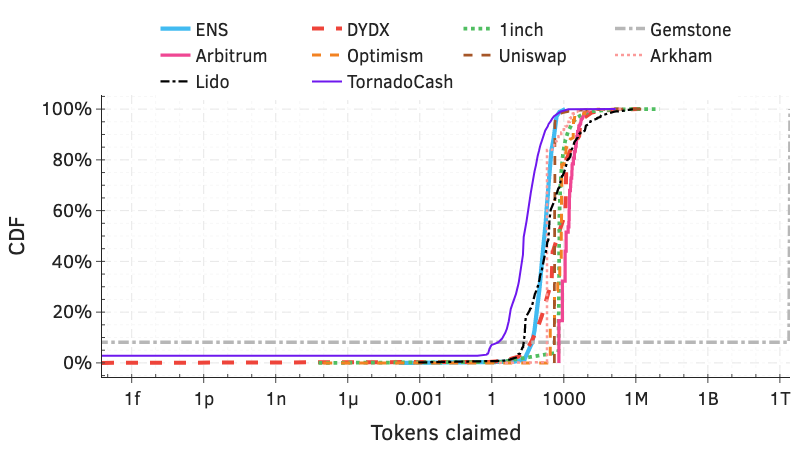

In [16]:
# Initialize the figure
fig = go.Figure(layout=get_plotly_layout(width=800, height=450))

for protocol in protocols:
    # Collect data once for the selected columns
    data = (
        dfs[protocol]['claim']
        .select(["timestamp", "amount"])
        .collect()
    )

    # Display protocol information and summary statistics
    display(HTML(f"<h3>{protocol}</h3>"))
    total_claimed = data['amount'].sum()
    print(
        f"The total amount of tokens claimed for {protocol} was {total_claimed}.")

    # Display descriptive statistics
    display(data['amount'].describe(
        percentiles=percentiles).transpose(column_names="statistic"))

    # Calculate ECDF using a single pass
    amounts = data["amount"].to_numpy()
    ecdf = ECDF(amounts)

    # Add ECDF trace to the plot
    fig.add_trace(go.Scatter(
        x=ecdf.x,
        y=ecdf.y,
        name=plot_settings[protocol]['label'],
        line=dict(
            color=plot_settings[protocol]['color'],
            width=plot_settings[protocol]['width'],
            dash=plot_settings[protocol]['style']
        )
    ))

# Update layout
fig.update_layout(
    xaxis_title='Tokens claimed',
    yaxis_title='CDF',
    legend=dict(xanchor='center', x=0.5, y=1.3, orientation='h')
)
fig.update_xaxes(type='log')
fig.update_yaxes(tickformat=".0%")

# Display the plot
fig.show("png")

In [17]:
for protocol, data in dfs.items():
    result = (
        data['claim']
        .select([
            pl.max('amount').alias("max_amount"),
            pl.sum('amount').alias("total_amount")
        ])
        .collect()
    )

    top_earner = result["max_amount"].item()
    total_amount = result["total_amount"].item()
    percentage = round(100 * top_earner / total_amount, 2)

    print(
        f"The top earner for {protocol} earned {top_earner} tokens, representing {percentage}% of all tokens distributed.")

The top earner for ens earned 1143.5442044346885 tokens, representing 0.01% of all tokens distributed.
The top earner for dydx earned 1492217.3787069707 tokens, representing 0.89% of all tokens distributed.
The top earner for 1inch earned 9749686.003287062 tokens, representing 11.66% of all tokens distributed.
The top earner for gemstone earned 2639000000000.0 tokens, representing 0.01% of all tokens distributed.
The top earner for arbitrum earned 10250.0 tokens, representing 0.0% of all tokens distributed.
The top earner for optimism earned 32431.799504666036 tokens, representing 0.02% of all tokens distributed.
The top earner for uniswap earned 2103516.5902480003 tokens, representing 1.53% of all tokens distributed.
The top earner for arkham earned 249353.4020813408 tokens, representing 0.85% of all tokens distributed.
The top earner for lido earned 746286.4909149566 tokens, representing 18.79% of all tokens distributed.
The top earner for tornado earned 143831.1575925667 tokens, rep

## Airdrop list

Lido list (https://docs.lido.fi/guides/1inch-pool-rewards):

- https://github.com/lidofinance/airdrop-data/blob/main/early_stakers_airdrop.csv
- https://github.com/lidofinance/airdrop-data/blob/main/oneinch_lido_airdrop.csv

Tornado list: https://github.com/tornadocash/airdrop/blob/master/airdrop.csv


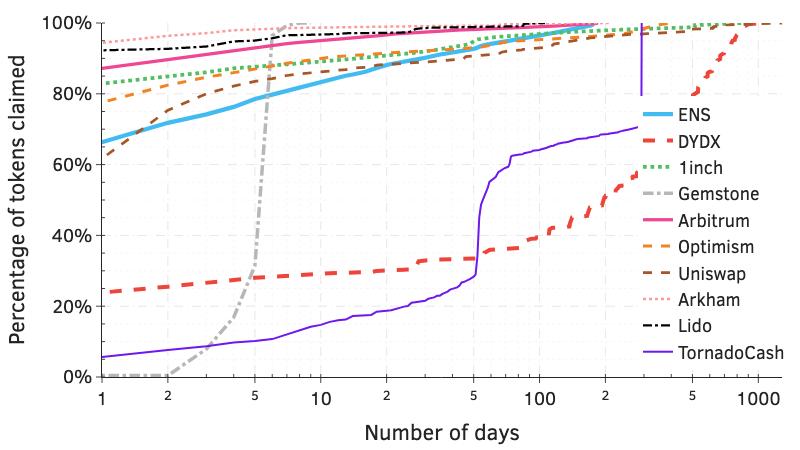

In [18]:
# Setup figure
fig = go.Figure(layout=get_plotly_layout(width=800, height=450))

for protocol in protocols:
    df = (
        dfs[protocol]['claim']
        .with_columns(pl.col("timestamp").cast(pl.Date).alias("date"))
        .group_by("date")
        .agg(pl.sum("amount").alias("daily_sum"))
        .sort("date")
        .with_columns([
            pl.col("daily_sum").cum_sum().alias("cumulative_sum"),
            pl.col("daily_sum").sum().alias("total_sum")
        ])
        .with_columns(
            (pl.col("cumulative_sum") / pl.col("total_sum")).alias("claimed_fraction")
        )
        .with_row_index(name="days_since_start")
        .select(["days_since_start", "claimed_fraction"])
        .collect()
    )

    fig.add_trace(go.Scatter(
        x=df["days_since_start"],
        y=df["claimed_fraction"],
        mode="lines",
        line=dict(
            color=plot_settings[protocol]['color'],
            width=plot_settings[protocol]['width'],
            dash=plot_settings[protocol]['style']
        ),
        name=plot_settings[protocol]['label']
    ))

# Update layout
fig.update_layout(
    xaxis_title="Number of days",
    yaxis_title="Percentage of tokens claimed",
    legend=dict(xanchor="center", x=0.9, y=0.02, orientation="v")
)
fig.update_xaxes(type="log")
fig.update_yaxes(tickformat=".0%", range=[0, 1])

# Export and display
fig.write_image(os.path.join(plots_dir, "tokens_claimed_per_day.pdf"))
fig.show("png")

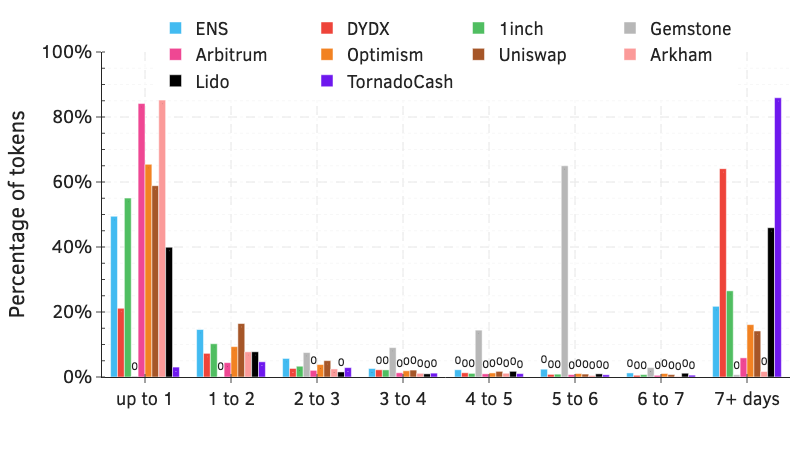

In [19]:
# Constants
bins = [0, 24, 48, 72, 96, 120, 144, 168]
bin_labels = ['up to 1', '1 to 2', '2 to 3',
              '3 to 4', '4 to 5', '5 to 6', '6 to 7', '7+ days']

# Plot setup
fig = go.Figure(layout=get_plotly_layout(width=800, height=450))

for protocol in protocols:
    # Compute delay in hours
    df = (
        dfs[protocol]['claim']
        .select(["timestamp", "amount"])
        .with_columns(
            (pl.col("timestamp") - pl.col("timestamp").min()
             ).dt.total_hours().alias("claim_delay_hour")
        )
        .collect()
    )

    # Bin and compute percentages
    binned = (
        df.select(pl.col("claim_delay_hour").cut(
            breaks=bins, left_closed=True).alias("bin"))
        .group_by("bin")
        .agg(pl.len().alias("count"))
        .with_columns(
            (pl.col("count") / pl.col("count").sum()).alias("percentage")
        )
        .sort("bin")
    )

    # Add bar to figure
    fig.add_trace(go.Bar(
        x=bin_labels,
        y=binned["percentage"],
        marker_color=plot_settings[protocol]['color'],
        text=binned["percentage"].round(1),
        textposition='auto',
        name=plot_settings[protocol]['label']
    ))

# Finalize plot
fig.update_layout(
    yaxis_title="Percentage of tokens",
    xaxis_title="",
    legend=dict(xanchor='center', x=0.5, y=1.13, orientation='h'),
)
fig.update_yaxes(range=[0, 1], tickformat=".0%")

# Save and show
fig.write_image(os.path.join(plots_dir, "claim_delay.pdf"))
fig.show("png")

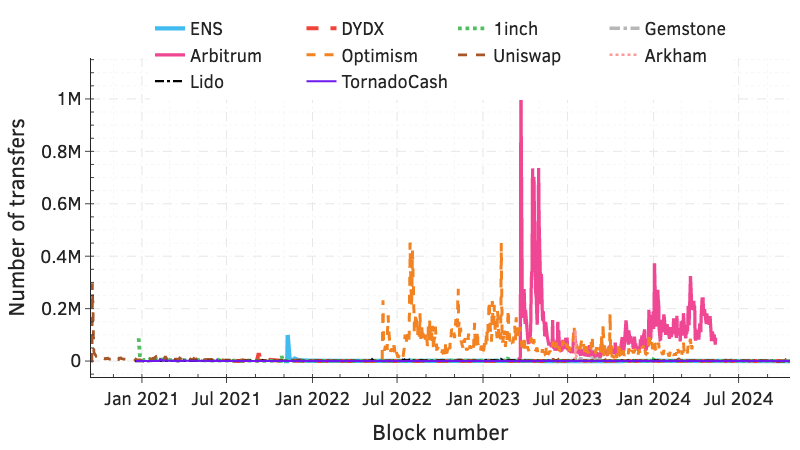

In [20]:
fig = go.Figure(layout=get_plotly_layout(width=800, height=450))

# Precompute dead address set once (if large) for faster membership checks
dead_address_set = set(dead_addresses)

for protocol in protocols:
    df = (
        dfs[protocol]['transfer']
        # Fast filtering
        .filter(~pl.col('sender').is_in(dead_address_set))
        # Convert once, reuse column
        .with_columns(pl.col('timestamp').cast(pl.Date).alias("date"))
        # Group by date directly
        .group_by('date')
        # Count all rows
        .agg(pl.len().alias('transfer_count'))
        # Chronological order
        .sort('date')
        .collect()
    )

    fig.add_trace(go.Scatter(
        x=df['date'],
        y=df['transfer_count'],
        mode='lines',
        line=dict(
            color=plot_settings[protocol]['color'],
            width=plot_settings[protocol]['width'],
            dash=plot_settings[protocol]['style']
        ),
        name=plot_settings[protocol]['label']
    ))

fig.update_layout(
    xaxis_title='Block number',
    yaxis_title='Number of transfers',
    legend=dict(xanchor='center', x=0.5, y=1.15, orientation='h')
)

fig.show("png")

## Graph network analysis


In [21]:
# Loading exchange addresses
# Define data paths
cex_path = os.path.join(data_dir, "cex_addresses.csv")
dex_path = os.path.join(data_dir, "dex_addresses.csv")

# Load data
exchange_cex_addresses_df = pl.read_csv(cex_path)
exchange_dex_addresses_df = pl.read_csv(dex_path)

# Union set of the exchanges
exchange_addresses_set = set(exchange_cex_addresses_df['address'].to_list(
) + exchange_dex_addresses_df['address'].to_list())

# Output the number of addresses
print(
    f"There are {exchange_cex_addresses_df.shape[0]} CEX addresses and {exchange_dex_addresses_df.shape[0]} DEX addresses.")

print(f"There are {len(exchange_addresses_set)} exchange addresses in total.")

# Adding fake exchange created during the Gemstone airdrop attack.
exchange_addresses_set.add('0x7aa1ed8fb5e820e38c86cf3dd0a9eb0169a149ad')

There are 3169 CEX addresses and 685 DEX addresses.
There are 3569 exchange addresses in total.


In [22]:
exchange_cex_dict = {
    row["address"]: {"name": row["name"],
                     "distinct_name": row["distinct_name"]}
    for row in exchange_cex_addresses_df.iter_rows(named=True)
}

exchange_dex_dict = {
    row["address"]: {"name": row["name"],
                     "distinct_name": row["distinct_name"]}
    for row in exchange_dex_addresses_df.iter_rows(named=True)
}

In [23]:
# addresses = dict()
# exchanges = dict()
# filedir = os.path.realpath(os.path.join(data_dir, "addresses_dic.json"))
# with open(filedir) as f:
#     addresses = json.load(f)
#     ads = list(addresses.keys())
#     for address in ads:
#         addresses[address.lower()] = addresses.pop(address)

# filedir = os.path.realpath(os.path.join(data_dir, "addresses.json"))
# with open(data_dir+filedir) as f:
#     addresses.update(json.load(f))
#     ads = list(addresses.keys())
#     for address in ads:
#         addresses[address.lower()] = addresses.pop(address)

# filedir = os.path.realpath(os.path.join(data_dir, "exchange_addresses.json"))
# with open(filedir) as f:
#     data = json.load(f)
#     for address in data.keys():
#         exchanges[address.lower()] = data[address]

# addresses.update(exchanges)
# print("There are {} exchanges addresses".format(len(exchanges)))
# print("There are {} addresses".format(len(addresses)))

In [24]:
# exchanges['0x1df4139144595e0245b084e7ea1a75101fb95548'] = 'Uniswap V2: 1INCH-DAI'
# exchanges['0xad570798fa568d93c52ee0f9839278959b13a49b'] = 'Uniswap V3: DYDX-USDT'
# exchanges['0x65f7ba4ec257af7c55fd5854e5f6356bbd0fb8ec'] = 'stkDYDX'
# exchanges['0x9687ec962a3a3f72e2c3b7604c31ccc7d1eec84a'] = 'Gemstone-to-check'
# exchanges['0xef523713706b93a31cfd083a2fe47847b714be55'] = 'Gemstone-to-check'
# exchanges['0x92fd143a8fa0c84e016c2765648b9733b0aa519e'] = 'Uniswap V3 - ARB/WETH' # Arbitrum
# exchanges['0xa8328bf492ba1b77ad6381b3f7567d942b000baf'] = 'Uniswap - ARB/USDC'
# exchanges['0x64768a3a2453f1e8de9e43e92d65fc36e4c9872d'] = 'Uniswap ARB-WETH'
# exchanges['0xfd086bc7cd5c481dcc9c85ebe478a1c0b69fcbb9'] = 'Uniswap - ARB/USDT'
# exchanges['0xc18360217d8f7ab5e7c516566761ea12ce7f9d72'] = 'ENS'
# exchanges['0x833af8617d03902efb4cc6f2eaa4d58ace6d3fc6'] = 'Gemstone'
# exchanges['0xc18360217d8f7ab5e7c516566761ea12ce7f9d72'] = 'ENS'

In [25]:
dfs['dydx']['transfer'].filter(
    pl.col('sender').eq('0x639192d54431f8c816368d3fb4107bc168d0e871')
).collect()

blockNumber,transactionHash,blockHash,address,transactionIndex,logIndex,event,sender,receiver,amount,timestamp
i64,str,str,str,i64,i64,str,str,str,f64,datetime[ns]
13183164,"""361400ec679147ed4575ac2215de48…","""66eebcd18b681919affcf267100740…","""0x92d6c1e31e14520e676a687f0a93…",18,35,"""Transfer""","""0x639192d54431f8c816368d3fb410…","""0x54af6a1dbacfa9dddd72a7dd1b4f…",1.584922969314624952e-1,2021-09-08 05:24:48
13185646,"""53629569beb5d8dd590edc169ea093…","""c9adf2ffc238e0fe42ad28cad4fb74…","""0x92d6c1e31e14520e676a687f0a93…",118,184,"""Transfer""","""0x639192d54431f8c816368d3fb410…","""0x75dc9a12bf02565136ddf3e27fcb…",0.000000000000000000e0,2021-09-08 14:23:45
13185813,"""751c7b32ba3ed77f59dc2776a910dc…","""bab2daf7004c944c5311039628208f…","""0x92d6c1e31e14520e676a687f0a93…",23,100,"""Transfer""","""0x639192d54431f8c816368d3fb410…","""0x8568e1a8082b442ae9be089a3b38…",1.178209769696859667e3,2021-09-08 15:00:53
13185813,"""f1664ae2da908ee8a71e88afe86d25…","""bab2daf7004c944c5311039628208f…","""0x92d6c1e31e14520e676a687f0a93…",156,240,"""Transfer""","""0x639192d54431f8c816368d3fb410…","""0x44acd0ff3be9fdfb932453c82b5d…",4.350810345703857820e3,2021-09-08 15:00:53
13185813,"""0f6a0ed8d5e6854709e12d57bb65b6…","""bab2daf7004c944c5311039628208f…","""0x92d6c1e31e14520e676a687f0a93…",158,252,"""Transfer""","""0x639192d54431f8c816368d3fb410…","""0xf7e39bfa90e8501fe2f2a1333e3e…",1.163646413569437755e3,2021-09-08 15:00:53
…,…,…,…,…,…,…,…,…,…,…
20980742,"""0b816841fe4e141a34c1cf8eeb5c0d…","""b6b23bceb44d7571f4962167f57555…","""0x92d6c1e31e14520e676a687f0a93…",10,59,"""Transfer""","""0x639192d54431f8c816368d3fb410…","""0x625ceba7f2fa59a6b10cfaed5c54…",8.055714889045527798e2,2024-10-16 21:14:47
20981977,"""ddcb3f6cc695249f4efef243791764…","""eb36ea2f0a2ae5a74aa7926e6c0a86…","""0x92d6c1e31e14520e676a687f0a93…",86,249,"""Transfer""","""0x639192d54431f8c816368d3fb410…","""0xd33211514b5ec7169236bdff3081…",0.000000000000000000e0,2024-10-17 01:23:35
20981977,"""ddcb3f6cc695249f4efef243791764…","""eb36ea2f0a2ae5a74aa7926e6c0a86…","""0x92d6c1e31e14520e676a687f0a93…",86,257,"""Transfer""","""0x639192d54431f8c816368d3fb410…","""0xd33211514b5ec7169236bdff3081…",5.718525010304958414e4,2024-10-17 01:23:35


In [26]:
airdrop_contracts = {
    "ens": {"0xc18360217d8f7ab5e7c516566761ea12ce7f9d72"},
    "dydx": {"0x639192d54431f8c816368d3fb4107bc168d0e871"},
    "1inch": {"0xe295ad71242373c37c5fda7b57f26f9ea1088afe"},
    "gemstone": {"0xdea197d9920a7472050013ad7e8de0733da81d5c"},
    "arbitrum": {"0x67a24ce4321ab3af51c2d0a4801c3e111d88c9d9"},
    "optimism": {"0xfedfaf1a10335448b7fa0268f56d2b44dbd357de"},
    "uniswap": {"0x090d4613473dee047c3f2706764f49e0821d256e"},
    "arkham": {"0x08c7676680f187a31241e83e6d44c03a98adab05"},
    "lido": {"0x4b3edb22952fb4a70140e39fb1add05a6b49622b", "0xdb46c277da1599390eab394327602889e9546296"},
    "tornado": {"0x3efa30704d2b8bbac821307230376556cf8cc39e"},
}

# For dYdX see the transfer event on the following transaction hash: https://etherscan.io/tx/0x361400ec679147ed4575ac2215de486c09e03994f5cc310f2648942f4e0abb82#eventlog

In [27]:
# Function to build graph for a protocol
def build_graph(data, protocol, airdrop_addresses):
    G = nx.MultiDiGraph(protocol=protocol)
    for row in data.iter_rows(named=True):
        if row['sender'] in airdrop_addresses:
            continue
        G.add_edge(
            row['sender'], row['receiver'],
            amount=row['amount'],
            timestamp=str(row['timestamp']),
            block_number=row['blockNumber']
        )
    return G

In [28]:
# Generate Graph Networks
Gs = {}
for protocol in tqdm(protocols, desc='Generating graph network'):
    print(f"Processing protocol: {protocol}")
    airdrop_addresses = airdrop_contracts.get(protocol, set())

    # Efficient data filtering
    data = (
        dfs[protocol]['transfer']
        .filter(~pl.col('sender').is_in(dead_addresses))
        .collect()
    )

    # Build graph
    Gs[protocol] = build_graph(data, protocol, airdrop_addresses)

    print(
        f"Protocol {protocol}: {Gs[protocol].number_of_nodes()} nodes, {Gs[protocol].number_of_edges()} edges"
    )

Generating graph network:   0%|          | 0/10 [00:00<?, ?it/s]

Processing protocol: ens
Protocol ens: 229991 nodes, 895792 edges
Processing protocol: dydx
Protocol dydx: 181000 nodes, 658614 edges
Processing protocol: 1inch
Protocol 1inch: 370372 nodes, 1739191 edges
Processing protocol: gemstone
Protocol gemstone: 20003 nodes, 240113 edges
Processing protocol: arbitrum
Protocol arbitrum: 2789879 nodes, 46747201 edges
Processing protocol: optimism
Protocol optimism: 1993397 nodes, 43829952 edges
Processing protocol: uniswap
Protocol uniswap: 1355596 nodes, 4651837 edges
Processing protocol: arkham
Protocol arkham: 129012 nodes, 219050 edges
Processing protocol: lido
Protocol lido: 127754 nodes, 1107066 edges
Processing protocol: tornado
Protocol tornado: 34536 nodes, 272973 edges


In [146]:
# Persist graphs
import pickle
for protocol, graph in tqdm(Gs.items()):
    graph_output = os.path.join(graph_dir, f"full_graph_{protocol}.gpickle")
    with gzip.open(graph_output, 'wb') as f:
        pickle.dump(graph, f, pickle.HIGHEST_PROTOCOL)

  0%|          | 0/10 [00:00<?, ?it/s]

In [29]:
addresses = set()
n_nodes = 150

# Iterate through each protocol in the graph data
for protocol, graph in Gs.items():
    # Extract the top 100 nodes by in-degree and convert to a DataFrame
    top_nodes = sorted(graph.in_degree(),
                       key=lambda x: x[1], reverse=True)[:n_nodes]
    data = pd.DataFrame(top_nodes, columns=["node", "degree"])
    addresses.update(data['node'].to_list())

    # Display the protocol and its top nodes
    # print(f"Protocol: {protocol}")
    # display(data)

# Output the total number of unique addresses
print("Total number of unique addresses:", len(addresses))

# Save the addresses to a CSV file
file_path = os.path.join(data_dir, "addresses_to_check.json")
with open(file_path, "w") as file:
    json.dump(list(addresses), file)

Total number of unique addresses: 1057


### Build a subgraph for each protocol containing only the claimers first transfers.

This is useful to plot the graphs


In [30]:
def show_graph_info(graph):
    print(f"Graph {graph.graph.get('protocol', 'Unknown')}")
    print(f"Nodes: {graph.number_of_nodes()}, Edges: {graph.number_of_edges()}")
    components = list(nx.connected_components(graph.to_undirected()))
    print(f"Connected Components: {len(components)}")
    if components:
        print(f"Largest Component Size: {len(max(components, key=len))}")


def cut_graph(graph, sources, cutoff=1):
    print(f"Cutting graph {graph.graph['protocol']} with cutoff {cutoff}")
    show_graph_info(graph)
    graph_dir = os.path.join(data_dir, "graphs")
    os.makedirs(graph_dir, exist_ok=True)

    # Collect reachable nodes efficiently
    reachable_nodes = set()
    for node_id in tqdm(sources, desc='Gathering reachable nodes'):
        if graph.has_node(node_id):
            reachable_nodes.update(nx.single_source_shortest_path_length(
                graph, node_id, cutoff=cutoff).keys())

    # Create subgraph
    sub_graph = graph.subgraph(reachable_nodes)
    show_graph_info(sub_graph)

    # Extract largest component
    components = list(nx.connected_components(sub_graph.to_undirected()))
    largest_component = max(components, key=len) if components else set()
    biggest_subgraph = sub_graph.subgraph(largest_component)

    # Save graphs
    nx.write_gexf(sub_graph, os.path.join(
        graph_dir, f"graph_{sub_graph.graph['protocol']}_cutoff_{cutoff}.gexf"))
    nx.write_gexf(biggest_subgraph, os.path.join(
        graph_dir, f"graph_{biggest_subgraph.graph['protocol']}_cutoff_{cutoff}_biggest_component.gexf"))

    return sub_graph

In [31]:
subgraphs = dict()
for protocol in tqdm(protocols):
    print(protocol)
    airdrop_claimers = dfs[protocol]['claim'].select(
        'receiver').unique().collect().to_series()
    subgraphs[protocol] = cut_graph(
        graph=Gs[protocol], sources=airdrop_claimers, cutoff=1)
    print()

  0%|          | 0/10 [00:00<?, ?it/s]

ens
Cutting graph ens with cutoff 1
Graph ens
Nodes: 229991, Edges: 895792
Connected Components: 1762
Largest Component Size: 225987


Gathering reachable nodes:   0%|          | 0/102824 [00:00<?, ?it/s]

Graph ens
Nodes: 129482, Edges: 318125
Connected Components: 18663
Largest Component Size: 85045

dydx
Cutting graph dydx with cutoff 1
Graph dydx
Nodes: 181000, Edges: 658614
Connected Components: 503
Largest Component Size: 179740


Gathering reachable nodes:   0%|          | 0/45944 [00:00<?, ?it/s]

Graph dydx
Nodes: 59109, Edges: 182330
Connected Components: 6477
Largest Component Size: 38325

1inch
Cutting graph 1inch with cutoff 1
Graph 1inch
Nodes: 370372, Edges: 1739191
Connected Components: 225
Largest Component Size: 369893


Gathering reachable nodes:   0%|          | 0/43806 [00:00<?, ?it/s]

Graph 1inch
Nodes: 58658, Edges: 461965
Connected Components: 5627
Largest Component Size: 45902

gemstone
Cutting graph gemstone with cutoff 1
Graph gemstone
Nodes: 20003, Edges: 240113
Connected Components: 1
Largest Component Size: 20003


Gathering reachable nodes:   0%|          | 0/20014 [00:00<?, ?it/s]

Graph gemstone
Nodes: 20002, Edges: 240111
Connected Components: 1
Largest Component Size: 20002

arbitrum
Cutting graph arbitrum with cutoff 1
Graph arbitrum
Nodes: 2789879, Edges: 46747201
Connected Components: 1869
Largest Component Size: 2785298


Gathering reachable nodes:   0%|          | 0/583137 [00:00<?, ?it/s]

Graph arbitrum
Nodes: 958315, Edges: 13379162
Connected Components: 57924
Largest Component Size: 805990

optimism
Cutting graph optimism with cutoff 1
Graph optimism
Nodes: 1993397, Edges: 43829952
Connected Components: 365
Largest Component Size: 1992580


Gathering reachable nodes:   0%|          | 0/160603 [00:00<?, ?it/s]

Graph optimism
Nodes: 228921, Edges: 8596353
Connected Components: 11765
Largest Component Size: 200195

uniswap
Cutting graph uniswap with cutoff 1
Graph uniswap
Nodes: 1355596, Edges: 4651837
Connected Components: 811
Largest Component Size: 1353809


Gathering reachable nodes:   0%|          | 0/221087 [00:00<?, ?it/s]

Graph uniswap
Nodes: 426163, Edges: 1928929
Connected Components: 13916
Largest Component Size: 395034

arkham
Cutting graph arkham with cutoff 1
Graph arkham
Nodes: 129012, Edges: 219050
Connected Components: 3124
Largest Component Size: 122409


Gathering reachable nodes:   0%|          | 0/64719 [00:00<?, ?it/s]

Graph arkham
Nodes: 100237, Edges: 109329
Connected Components: 9771
Largest Component Size: 75825

lido
Cutting graph lido with cutoff 1
Graph lido
Nodes: 127754, Edges: 1107066
Connected Components: 2
Largest Component Size: 127751


Gathering reachable nodes:   0%|          | 0/507 [00:00<?, ?it/s]

Graph lido
Nodes: 679, Edges: 168992
Connected Components: 7
Largest Component Size: 669

tornado
Cutting graph tornado with cutoff 1
Graph tornado
Nodes: 34536, Edges: 272973
Connected Components: 63
Largest Component Size: 34387


Gathering reachable nodes:   0%|          | 0/5347 [00:00<?, ?it/s]

Graph tornado
Nodes: 5739, Edges: 45541
Connected Components: 171
Largest Component Size: 4977



### How long does it take for the airdropped tokens to reach an exchange?


In [32]:
def calculate_hops(graph, exchange_addresses, claimant_data, claimant_nodes):
    from datetime import datetime
    hops = {"timestamp": dict(), "blocks": dict()}
    for node in claimant_nodes:
        if node in exchange_addresses or node not in graph:
            continue

        edges_sorted = [
            (neighbour, edge_data)
            for neighbour, node_indices in graph[node].items()
            for node_index, edge_data in node_indices.items()
        ]

        # Sort edges by block number
        edges_sorted.sort(key=lambda x: x[1]['block_number'])

        for neighbour, edge_data in edges_sorted:
            if neighbour in exchange_addresses:
                date_mask = "%Y-%m-%d %H:%M:%S" if protocol != "arbitrum" else "%Y-%m-%d %H:%M:%S%z"
                hops['timestamp'][node] = datetime.strptime(
                    edge_data['timestamp'], date_mask) - claimant_data[node]['timestamp']
                hops['blocks'][node] = edge_data['block_number'] - \
                    claimant_data[node]['block_number']
                break

    return hops


def process_hops(hops_data, mode):
    hops_df = pl.DataFrame(
        [(node, hop) for node, hop in hops_data.items()],
        schema=['node', 'hops'],
        orient="row"
    ).sort('hops')

    if mode == 'time':
        # hops_df = hops_df.with_columns(
        #     (pl.col('hops').dt.total_days()).alias('hops')
        # ).filter(pl.col('hops') >= 0)
        hops_df = hops_df.with_columns(
            (pl.col('hops').dt.total_seconds()/3600/24).alias('hops')
        ).filter(pl.col('hops') >= 0)
        display(hops_df['hops'].describe(
            percentiles=percentiles).transpose(column_names="statistic"))
    else:
        hops_df = hops_df.filter(pl.col('hops') >= 0)
        display(hops_df['hops'].describe(
            percentiles=percentiles).transpose(column_names="statistic"))

    return hops_df

In [33]:
hops_dict = {}
hops_dfs = {"time": dict(), "blocks": dict()}
for protocol in tqdm(protocols):
    print(protocol)
    claimant_nodes = dfs[protocol]['claim'].select(
        'receiver').unique().collect().to_series().to_list()

    # Collect the data once, minimizing unnecessary collects
    claimant_df = dfs[protocol]['claim'].select(
        ['receiver', 'blockNumber', 'timestamp']).collect()

    # Create the dictionary
    claimant_dict = {row['receiver']: {"block_number": row['blockNumber'],
                                       "timestamp": row['timestamp']} for row in claimant_df.iter_rows(named=True)}

    # Calculate time hops
    hops_dict[protocol] = calculate_hops(
        graph=Gs[protocol],
        exchange_addresses=exchange_addresses_set,
        claimant_data=claimant_dict,
        claimant_nodes=claimant_nodes,
    )
    print("number of days")
    hops_dfs['time'][protocol] = process_hops(
        hops_dict[protocol]['timestamp'], mode='time')
    print("number of blocks")
    hops_dfs['blocks'][protocol] = process_hops(
        hops_dict[protocol]['blocks'], mode='block')

  0%|          | 0/10 [00:00<?, ?it/s]

ens
number of days


count,null_count,mean,std,min,1%,5%,10%,20%,25%,50%,75%,80%,90%,95%,99%,max
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
5.357300000000000000e4,0.000000000000000000e0,6.935702815939620791e1,1.729675217677436763e2,0.000000000000000000e0,1.608796296296296103e-3,3.217592592592592206e-3,5.243055555555554623e-3,1.269675925925925833e-2,2.024305555555555580e-2,1.039791666666666448e0,3.051108796296296077e1,6.097833333333333172e1,2.196583333333333314e2,4.550642129629629835e2,8.725285416666666833e2,1.073653738425925894e3


number of blocks


count,null_count,mean,std,min,1%,5%,10%,20%,25%,50%,75%,80%,90%,95%,99%,max
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
5.357300000000000000e4,0.000000000000000000e0,4.584305565863401280e5,1.168176784386072075e6,0.000000000000000000e0,1.000000000000000000e1,2.100000000000000000e1,3.500000000000000000e1,8.200000000000000000e1,1.320000000000000000e2,6.584000000000000000e3,1.929120000000000000e5,3.897510000000000000e5,1.392529000000000000e6,3.008689000000000000e6,5.976973000000000000e6,7.407583000000000000e6


dydx
number of days


count,null_count,mean,std,min,1%,5%,10%,20%,25%,50%,75%,80%,90%,95%,99%,max
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
1.083000000000000000e4,0.000000000000000000e0,3.708731263038199444e1,1.193159741055207661e2,0.000000000000000000e0,6.944444444444443625e-4,1.192129629629629572e-3,1.747685185185185019e-3,3.113425925925925736e-3,4.166666666666666609e-3,4.016203703703703776e-2,9.779224537037036313e0,1.820512731481481339e1,8.582152777777777430e1,2.417873611111110961e2,6.802038078703703832e2,1.091446296296296168e3


number of blocks


count,null_count,mean,std,min,1%,5%,10%,20%,25%,50%,75%,80%,90%,95%,99%,max
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
1.083000000000000000e4,0.000000000000000000e0,2.475277864265927928e5,8.041786733276442392e5,0.000000000000000000e0,5.000000000000000000e0,8.000000000000000000e0,1.200000000000000000e1,2.100000000000000000e1,2.700000000000000000e1,2.640000000000000000e2,6.400500000000000000e4,1.183610000000000000e5,5.639070000000000000e5,1.617308000000000000e6,4.601783000000000000e6,7.488241000000000000e6


1inch
number of days


count,null_count,mean,std,min,1%,5%,10%,20%,25%,50%,75%,80%,90%,95%,99%,max
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2.615000000000000000e4,0.000000000000000000e0,2.495531618688478304e1,1.071482022852551665e2,0.000000000000000000e0,8.217592592592591659e-4,1.655092592592592553e-3,2.662037037037036542e-3,5.347222222222221960e-3,7.488425925925926152e-3,6.549768518518517268e-2,2.367511574074073977e0,6.370902777777777359e0,3.753766203703703752e1,1.142339814814814787e2,6.167737037037036316e2,1.352727916666666715e3


number of blocks


count,null_count,mean,std,min,1%,5%,10%,20%,25%,50%,75%,80%,90%,95%,99%,max
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2.615000000000000000e4,0.000000000000000000e0,1.630727445124282967e5,7.073604963627303950e5,0.000000000000000000e0,6.000000000000000000e0,1.100000000000000000e1,1.700000000000000000e1,3.500000000000000000e1,4.900000000000000000e1,4.200000000000000000e2,1.542600000000000000e4,4.143200000000000000e4,2.442830000000000000e5,7.435630000000000000e5,3.941358000000000000e6,9.180973000000000000e6


gemstone
number of days


count,null_count,mean,std,min,1%,5%,10%,20%,25%,50%,75%,80%,90%,95%,99%,max
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2.000000000000000000e4,0.000000000000000000e0,2.209570691666666420e1,1.105750629630558368e0,1.240592592592592425e1,1.997707175925926038e1,2.087863425925925753e1,2.100541666666666529e1,2.117644675925925668e1,2.126960648148148181e1,2.191164351851851677e1,2.260091435185184849e1,2.295687500000000014e1,2.384532407407407462e1,2.433804398148147996e1,2.502116898148148039e1,3.274844907407407391e1


number of blocks


count,null_count,mean,std,min,1%,5%,10%,20%,25%,50%,75%,80%,90%,95%,99%,max
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2.000000000000000000e4,0.000000000000000000e0,1.876824908250000095e6,9.351839226564561250e4,1.059567000000000000e6,1.696622000000000000e6,1.774123000000000000e6,1.784896000000000000e6,1.799214000000000000e6,1.807032000000000000e6,1.861412000000000000e6,1.918785000000000000e6,1.949186000000000000e6,2.024748000000000000e6,2.066707000000000000e6,2.124648000000000000e6,2.777465000000000000e6


arbitrum
number of days


count,null_count,mean,std,min,1%,5%,10%,20%,25%,50%,75%,80%,90%,95%,99%,max
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2.347830000000000000e5,0.000000000000000000e0,6.145674276274183256e1,1.070018747468864575e2,0.000000000000000000e0,4.398148148148148099e-4,1.307870370370370263e-3,3.310185185185185106e-3,1.744212962962962687e-2,4.028935185185185397e-2,5.131157407407407334e0,5.838393518518518732e1,1.135637615740740785e2,2.530844212962962843e2,3.283514236111111018e2,3.906691087962963138e2,4.183665509259258783e2


number of blocks


count,null_count,mean,std,min,1%,5%,10%,20%,25%,50%,75%,80%,90%,95%,99%,max
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2.347830000000000000e5,0.000000000000000000e0,2.037995083361231536e7,3.522060383297082037e7,0.000000000000000000e0,1.530000000000000000e2,4.660000000000000000e2,1.183000000000000000e3,6.291000000000000000e3,1.480400000000000000e4,1.779440000000000000e6,1.987701600000000000e7,3.843865600000000000e7,8.299331000000000000e7,1.079288850000000000e8,1.290139510000000000e8,1.384769450000000000e8


optimism
number of days


count,null_count,mean,std,min,1%,5%,10%,20%,25%,50%,75%,80%,90%,95%,99%,max
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
9.760500000000000000e4,0.000000000000000000e0,7.024454415437219268e1,1.374414164176050974e2,1.736111111111110906e-4,6.944444444444443625e-4,1.238425925925925805e-3,2.083333333333333304e-3,4.687499999999999827e-3,6.979166666666666505e-3,2.974999999999999867e-1,6.369903935185185162e1,1.193825925925925873e2,2.621604745370370324e2,3.847285416666666720e2,6.030858333333333121e2,6.627693865740740193e2


number of blocks


count,null_count,mean,std,min,1%,5%,10%,20%,25%,50%,75%,80%,90%,95%,99%,max
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
9.760500000000000000e4,0.000000000000000000e0,1.449476561350340582e7,2.902845215260570496e7,1.100000000000000000e1,1.020000000000000000e2,3.230000000000000000e2,6.820000000000000000e2,2.071000000000000000e3,3.436000000000000000e3,1.596000000000000000e5,7.927293000000000000e6,1.715983700000000000e7,6.530532200000000000e7,9.503786900000000000e7,1.053212830000000000e8,1.083863840000000000e8


uniswap
number of days


count,null_count,mean,std,min,1%,5%,10%,20%,25%,50%,75%,80%,90%,95%,99%,max
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
1.185160000000000000e5,0.000000000000000000e0,3.227281931127755144e1,1.193297773033927456e2,0.000000000000000000e0,1.145833333333333339e-3,2.037037037037036855e-3,3.229166666666666644e-3,7.037037037037036959e-3,1.015046296296296183e-2,1.093981481481481471e-1,4.188333333333332575e0,1.237412037037037038e1,8.213049768518517624e1,1.617516666666666652e2,6.378654745370370165e2,1.490025011574073915e3


number of blocks


count,null_count,mean,std,min,1%,5%,10%,20%,25%,50%,75%,80%,90%,95%,99%,max
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
1.185160000000000000e5,0.000000000000000000e0,2.106023037986432319e5,7.868297098038548138e5,0.000000000000000000e0,7.000000000000000000e0,1.400000000000000000e1,2.200000000000000000e1,4.600000000000000000e1,6.600000000000000000e1,7.150000000000000000e2,2.728100000000000000e4,8.003300000000000000e4,5.333070000000000000e5,1.051662000000000000e6,4.099394000000000000e6,1.009935300000000000e7


arkham
number of days


count,null_count,mean,std,min,1%,5%,10%,20%,25%,50%,75%,80%,90%,95%,99%,max
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
1.010700000000000000e4,0.000000000000000000e0,1.136608638952101380e1,4.771252033436901030e1,4.166666666666666392e-4,6.944444444444443625e-4,1.111111111111110893e-3,1.111111111111110893e-3,1.805555555555555473e-3,2.499999999999999618e-3,1.152777777777777742e-2,2.022222222222222199e-1,4.934722222222222010e-1,7.010694444444443896e0,6.285999999999999943e1,2.680705555555555293e2,4.567563888888888641e2


number of blocks


count,null_count,mean,std,min,1%,5%,10%,20%,25%,50%,75%,80%,90%,95%,99%,max
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
1.010700000000000000e4,0.000000000000000000e0,8.114948224003166251e4,3.406124311109982082e5,3.000000000000000000e0,5.000000000000000000e0,8.000000000000000000e0,8.000000000000000000e0,1.300000000000000000e1,1.800000000000000000e1,8.200000000000000000e1,1.440000000000000000e3,3.516000000000000000e3,5.006600000000000000e4,4.488430000000000000e5,1.912768000000000000e6,3.263421000000000000e6


lido
number of days


count,null_count,mean,std,min,1%,5%,10%,20%,25%,50%,75%,80%,90%,95%,99%,max
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2.330000000000000000e2,0.000000000000000000e0,5.532172428866634561e1,1.674650852020652394e2,4.745370370370370389e-4,1.273148148148148034e-3,2.314814814814814686e-3,3.240740740740740648e-3,6.747685185185184689e-3,9.016203703703703359e-3,1.075069444444444411e0,2.016417824074073906e1,2.716302083333333428e1,1.423623148148147948e2,2.528201620370370222e2,9.541141203703703013e2,1.099553715277777656e3


number of blocks


count,null_count,mean,std,min,1%,5%,10%,20%,25%,50%,75%,80%,90%,95%,99%,max
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2.330000000000000000e2,0.000000000000000000e0,3.616715622317596572e5,1.104976548513929127e6,7.000000000000000000e0,7.000000000000000000e0,1.600000000000000000e1,2.200000000000000000e1,4.600000000000000000e1,5.800000000000000000e1,6.974000000000000000e3,1.310500000000000000e5,1.764750000000000000e5,9.116000000000000000e5,1.620951000000000000e6,6.341581000000000000e6,7.382139000000000000e6


tornado
number of days


count,null_count,mean,std,min,1%,5%,10%,20%,25%,50%,75%,80%,90%,95%,99%,max
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2.941000000000000000e3,0.000000000000000000e0,4.605914384515848781e1,1.143115863000698056e2,3.935185185185185227e-4,1.018518518518518427e-3,1.666666666666666557e-3,2.314814814814814686e-3,4.699074074074074264e-3,6.990740740740740075e-3,2.857175925925925952e0,4.937684027777777374e1,5.211081018518518704e1,9.484821759259259011e1,2.310719791666666652e2,5.540162731481481160e2,1.248517418981481342e3


number of blocks


count,null_count,mean,std,min,1%,5%,10%,20%,25%,50%,75%,80%,90%,95%,99%,max
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2.941000000000000000e3,0.000000000000000000e0,2.988199761985719088e5,7.461752248627364170e5,3.000000000000000000e0,7.000000000000000000e0,1.100000000000000000e1,1.600000000000000000e1,3.000000000000000000e1,4.600000000000000000e1,1.856500000000000000e4,3.212460000000000000e5,3.391930000000000000e5,6.155800000000000000e5,1.494128000000000000e6,3.541882000000000000e6,8.449787000000000000e6


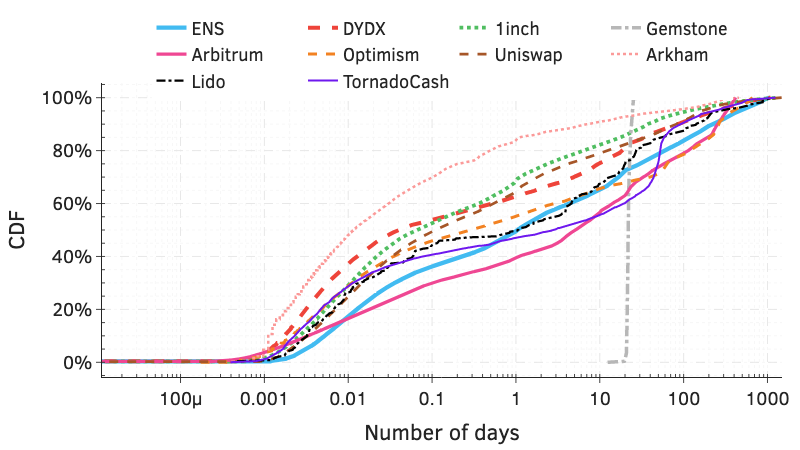

In [34]:
fig = go.Figure(layout=get_plotly_layout(width=800, height=450))
for protocol in protocols:
    ecdf = ECDF(hops_dfs['time'][protocol]['hops'])
    fig.add_trace(go.Scatter(x=ecdf.x,
                             y=ecdf.y,
                             name=plot_settings[protocol]['label'],
                             line=dict(
                                 color=plot_settings[protocol]['color'],
                                 width=plot_settings[protocol]['width'],
                                 dash=plot_settings[protocol]['style']
                             )
                             )
                  )

fig.update_layout(
    xaxis_title='Number of days',
    yaxis_title='CDF',
    legend=dict(xanchor='center', x=0.5, y=1.25, orientation='h'))

fig.update_xaxes(type='log')
fig.update_yaxes(tickformat=".0%")
output_path = os.path.join(plots_dir, "number_of_days_until_exchange_log.pdf")
fig.write_image(output_path)
fig.show("png")

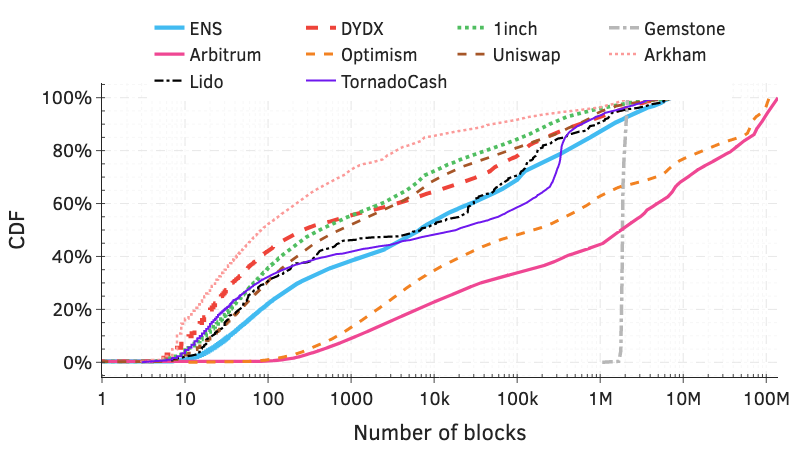

In [35]:
fig = go.Figure(layout=get_plotly_layout(width=800, height=450))
for protocol in protocols:
    ecdf = ECDF(hops_dfs['blocks'][protocol]['hops'])
    fig.add_trace(go.Scatter(x=ecdf.x, y=ecdf.y, name=plot_settings[protocol]['label'],
                             line=dict(color=plot_settings[protocol]['color'],
                             width=plot_settings[protocol]['width'],
                             dash=plot_settings[protocol]['style'])))

fig.update_layout(
    xaxis_title='Number of blocks',
    yaxis_title='CDF',
    legend=dict(xanchor='center', x=0.5, y=1.25, orientation='h'))

fig.update_xaxes(type='log')
fig.update_yaxes(tickformat=".0%")
output_path = os.path.join(
    plots_dir, "number_of_blocks_until_exchange_log.pdf")
fig.show("png")

In [164]:
target_addresses = exchange_addresses_set.copy()
with open(os.path.join(data_dir, "exchanges_addresses.json"), "w") as f:
    json.dump(list(target_addresses), f)

claim_receivers = dict()
for protocol, data in dfs.items():
    claim_receivers[protocol] = data['claim'].select(
        pl.col("receiver").unique()
        ).collect()['receiver'].to_list()

with open(os.path.join(data_dir, "claim_receivers_addresses.json"), "w") as f:
    json.dump(claim_receivers, f)